## Can we use SAEs to detect synthetic data?


1 MLKRLIQGFESFKRDYYTKHRKLFEELKKGQKPTVALFSCSDSRINPNQITQSNLGEIFIIRNAGNLVPPYDSSNYGTSAAIEFAVCSLGVENIIVLGHSHCGGIEAILKEEGEKSFNKLVNKWMKIADTAKDLLKNHLPDEDQLRKAAEINVRTQLDHLQSYPFISKKLKENELSIHAWVYHIQTGSVFTFSQEKSGYFELEQKKINE
2 MSQVPDTPPSGEPSTAAQSERDADDELKYLVDGVRHFKNEVFPGQEELFKSLAKAQHPKTMFITCADSRLLTSEVTSASAGDIFVVRNICNTAAVQVDGGGVTSLTYPIIHSFEVAAAVLEVKHIIVCGHSDCSSMKGAVNPDGLTKFVADYVQNAKPALERFPSEKLNSVAEKNVRSSAELIRRSPMLAEMEEKGELNLHAWVFEIADGKLFFTEEAGEYVPVS
3 MSTDSSTPSEAWKQLEEGNRRFVSGQILHSRNRQDMTASAKEHEDGQHPWAVVLTCSDSRVPPESLFDQRPGDIFVIRTAGQVFSAEIGGSSAIDYAIKALGVTDVIVMGHTSCGAMTATVEAYSQGDPLSTTNLGSALKAIEPAVQQALEESDGLDAEDEAMVRHAVDLNVRRSIESVRARTTVPTALQHGSLKIVGATYHLEDGRTEII
4 MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHYGCGGVQAAVENPELGLINNWLLHIRDIWFKHSSLLGEMPQERRLDTLCELNVMEQVYNLGHSTIMQSAWKRGQKVTIHGWAYGIHDGLLRDLDVTATNRETLEQRYRHGISNLKLKHANHK

In [1]:
import sys
import os

# Get the absolute path to the src directory
src_path = os.path.abspath(os.path.join('../../'))

# Add it to sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
sequences = [
"MLKRLIQGFESFKRDYYTKHRKLFEELKKGQKPTVALFSCSDSRINPNQITQSNLGEIFIIRNAGNLVPPYDSSNYGTSAAIEFAVCSLGVENIIVLGHSHCGGIEAILKEEGEKSFNKLVNKWMKIADTAKDLLKNHLPDEDQLRKAAEINVRTQLDHLQSYPFISKKLKENELSIHAWVYHIQTGSVFTFSQEKSGYFELEQKKINE",
"MSQVPDTPPSGEPSTAAQSERDADDELKYLVDGVRHFKNEVFPGQEELFKSLAKAQHPKTMFITCADSRLLTSEVTSASAGDIFVVRNICNTAAVQVDGGGVTSLTYPIIHSFEVAAAVLEVKHIIVCGHSDCSSMKGAVNPDGLTKFVADYVQNAKPALERFPSEKLNSVAEKNVRSSAELIRRSPMLAEMEEKGELNLHAWVFEIADGKLFFTEEAGEYVPVS",
"MSTDSSTPSEAWKQLEEGNRRFVSGQILHSRNRQDMTASAKEHEDGQHPWAVVLTCSDSRVPPESLFDQRPGDIFVIRTAGQVFSAEIGGSSAIDYAIKALGVTDVIVMGHTSCGAMTATVEAYSQGDPLSTTNLGSALKAIEPAVQQALEESDGLDAEDEAMVRHAVDLNVRRSIESVRARTTVPTALQHGSLKIVGATYHLEDGRTEII",
"MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSRVPAERLTGLEPGELFVHRNVANLVIHTDLNCLSVVQYAVDVLEVEHIIICGHYGCGGVQAAVENPELGLINNWLLHIRDIWFKHSSLLGEMPQERRLDTLCELNVMEQVYNLGHSTIMQSAWKRGQKVTIHGWAYGIHDGLLRDLDVTATNRETLEQRYRHGISNLKLKHANHK"
]


In [21]:
import torch

import json
import os
from src.inference.inference_batch_topk import convert_to_jumprelu
from src.utils import load_sae, load_model, get_ht_model
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hierarchy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, vstack
from src.utils import get_paths
paths = get_paths()
model_path = paths.model_path
sae_path = paths.sae_path

tokenizer, model = load_model(model_path)
model = get_ht_model(model, model.config).to("cuda")
cfg, sae = load_sae(sae_path)
thresholds = torch.load(sae_path+"/percentiles/feature_percentile_99.pt")
thresholds = torch.where(thresholds > 0, thresholds, torch.inf)
sae.to("cuda")
jump_relu = convert_to_jumprelu(sae, thresholds)
jump_relu.eval()
del sae
torch.cuda.empty_cache()


Moving model to device:  cuda


In [11]:

import numpy as np

def softmax(logits):
    """Convert logits to probabilities using softmax."""
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))  # Numerical stability
    return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

def compute_perplexity(logits, tokens):
    """
    Compute the perplexity of a sequence given logits and tokens.

    Args:
        logits (np.ndarray): Logits from the model, shape (sequence_length, vocab_size).
        tokens (list or np.ndarray): Ground truth token IDs, shape (sequence_length,).

    Returns:
        float: Perplexity of the sequence.
    """
    # Convert logits to probabilities
    probs = softmax(logits)

    # Get the predicted probabilities for the ground truth tokens
    token_probs = probs[np.arange(len(tokens)), tokens]

    # Avoid log(0) by clipping probabilities to a small value
    token_probs = np.clip(token_probs, a_min=1e-10, a_max=1.0)

    # Compute the negative log-likelihood (NLL)
    nll = -np.log(token_probs)

    # Average the NLL over the sequence
    #avg_nll = np.mean(nll)

    # Compute perplexity
    perplexity = np.exp(nll)

    return perplexity

In [6]:
probes_path = "../../Data/Detect_Synth_Data/probes"
probes = []
coefs = []
files = os.listdir(probes_path)
for file in files:
    if file.endswith(".npy"):
        probes.append(np.load(os.path.join(probes_path, file), allow_pickle=True).tolist())
        coefs.append(np.load(os.path.join(probes_path, file), allow_pickle=True).tolist().coef_)

## Get representations without EC labels

In [22]:
names_filter = lambda x: x.endswith("26.hook_resid_pre")
ec = "4.2.1.46"
all_logits = []
all_activations = []
all_perplexities = []
with torch.no_grad():
    for seq in sequences:
        inputs = tokenizer.encode(seq, return_tensors="pt").to("cuda")
        logits, cache = model.run_with_cache(inputs, names_filter=names_filter)
        all_activations.append(cache["blocks.26.hook_resid_pre"])
        all_logits.append(logits)
        perplexity = compute_perplexity(logits[0].detach().cpu().numpy()[1:], inputs[0].cpu().numpy()[:-1])
        all_perplexities.append(perplexity)
torch.save(all_activations, "all_activations_no_ec.pt")
del model
torch.cuda.empty_cache()

In [8]:
all_features = []
for activations in all_activations:
    feature_acts = jump_relu.forward(activations, use_pre_enc_bias=True)["feature_acts"]
    sparse_feature_acts = coo_matrix(feature_acts[0].detach().cpu().numpy())
    del feature_acts
    torch.cuda.empty_cache()
    all_features.append(sparse_feature_acts)




### Compute the perplexity for each sequence

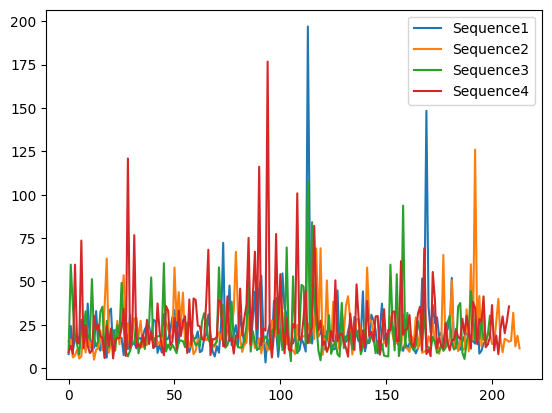

In [27]:
plt.plot(all_perplexities[0][10:], label = "Sequence1")
plt.plot(all_perplexities[1][10:], label = "Sequence2")
plt.plot(all_perplexities[2][10:], label = "Sequence3")
plt.plot(all_perplexities[3][10:], label = "Sequence4")
plt.legend()
plt.show()

## Compute scores for all probes

In [31]:
score_per_probe = {}
for i, coef in enumerate(coefs):
    score_per_probe[i] = {} 
    for j, feature in enumerate(all_features):
        score_per_probe[i][j] = coef @ feature.toarray().T




## Heatmap of scores for each probe

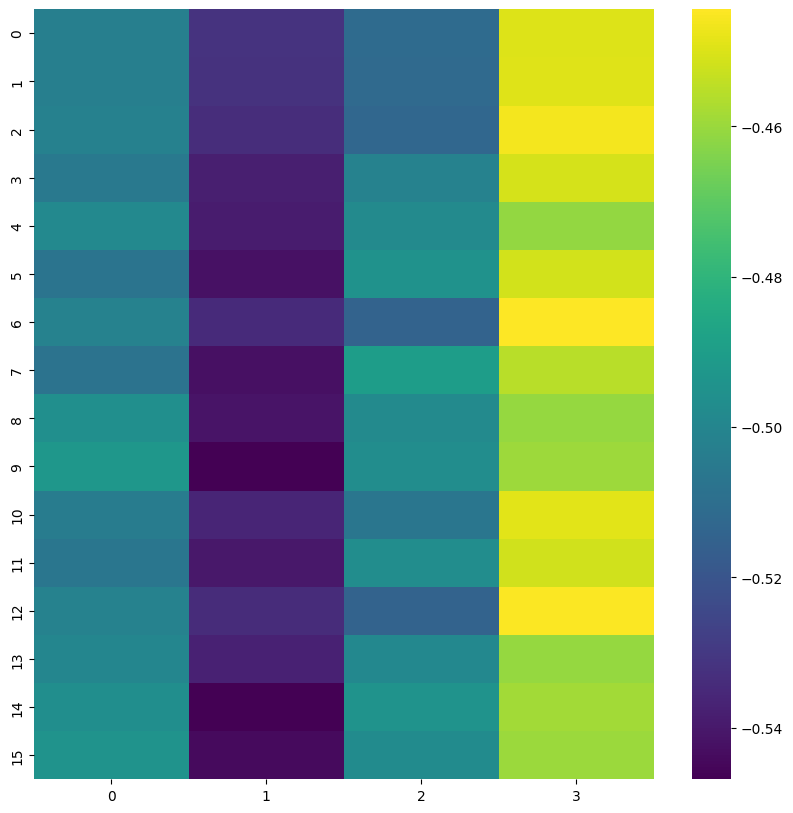

In [ ]:
X = np.array([[score_per_probe[i][j] for j in range(len(all_features))] for i in range(4,len(probes))])
X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
plt.figure(figsize=(10, 10))
sns.heatmap(X_norm, cmap="viridis")
plt.show()




## Correlation between score and perplexity

In [34]:
scores = score_per_probe[5]
scores

{0: array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.30856326,  0.        , -0.49961954,  0.        , -0.61631265,
         -1.05723127, -0.51165137, -0.79811829, -1.17446289, -1.52913776,
         -1.45871045, -1.76334359, -2.09906677, -2.27192632, -1.77004793,
         -1.68703883, -1.79575133, -2.26747261, -2.26476688, -2.50096552,
         -3.01534608, -2.56498313, -2.68162852, -1.80808893, -1.96171601,
         -1.96676063, -1.73647159, -1.92844722, -1.65842635, -1.83460406,
         -1.8433461 , -1.92853507, -2.00785673, -1.60147236, -2.34360764,
         -2.28489045, -1.93290141, -0.77073844, -0.94726956, -0.95562473,
         -0.86723445, -0.67358879, -1.29391275, -0.96259234, -0.94936523,
         -0.55190267, -0.70590133, -0.70795418, -0.75682909, -1.01024659,
         -1.10760472, -1.01959734, -0.94683181, -1.16784946, -1.39232793,
         -1.63066768, -1.74861126, 

In [28]:

probs_per_probe = {}
for i, probe in enumerate(probes):
    probs_per_probe[i] = {} 
    for j, feature in enumerate(all_features):
        probs = probe.predict_proba(feature)[:,1].mean()
        

        probs_per_probe[i][j] = probs

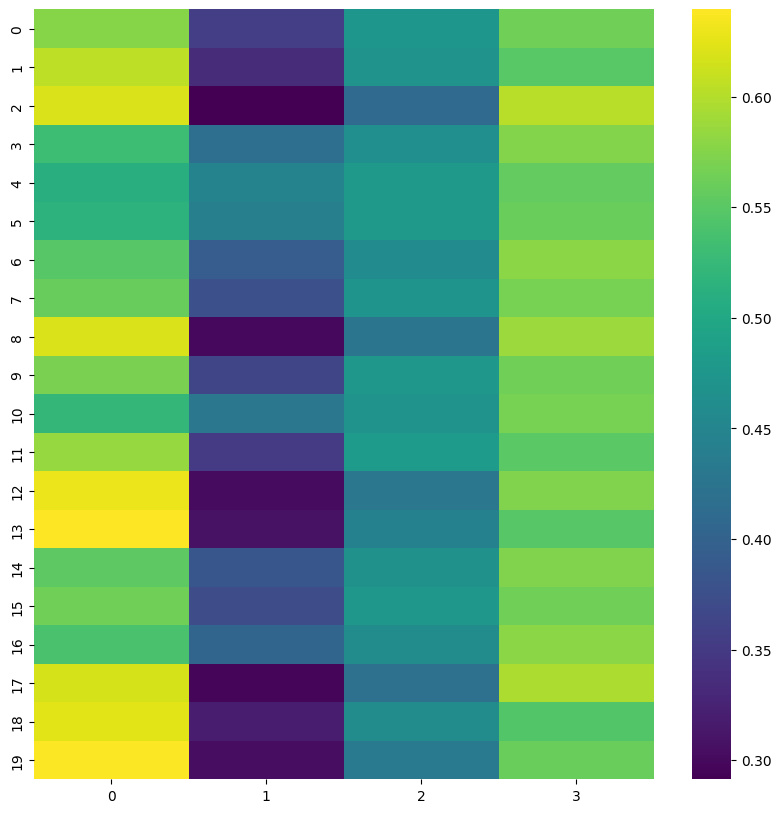

In [31]:
X = np.array([[probs_per_probe[i][j] for j in range(len(all_features))] for i in range(len(probes))])
X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
plt.figure(figsize=(10, 10))
sns.heatmap(X_norm, cmap="viridis")
plt.show()


